# Sentiment Analysis
Sentiment analysis of Indonesian online marketplace app reviews.

Steps:
1. EDA and data cleaning
2. Modelling using LSTM

## Loading Dependencies

In [1]:
import re

import numpy as np
import pandas as pd

# Visualization
import seaborn as sns

# Google cloud
from google.oauth2 import service_account
from google.cloud import bigquery

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow import keras
from keras.losses import CategoricalCrossentropy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

2022-01-08 02:40:22.565334: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-08 02:40:22.565396: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
key_path = '../airflow/credentials/future-data-track-1-sapporo.json'
credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

bigquery_client = bigquery.Client(
    project='future-data-track-1',
    credentials=credentials
)

In [3]:
query = """
WITH t AS (
  SELECT *
  FROM `future-data-track-1.sapporo_mart.sentiment_analysis`
),
table_stats AS (
  SELECT *, SUM(c) OVER() total 
  FROM (
    SELECT sentiment, COUNT(*) c 
    FROM t
    GROUP BY 1 
    HAVING c>100000)
)
SELECT sample.*
FROM (
SELECT ARRAY_AGG(a ORDER BY RAND() LIMIT 20000) cat_samples, sentiment, ANY_VALUE(c) c
FROM t a
JOIN table_stats b
USING(sentiment)
GROUP BY sentiment
), UNNEST(cat_samples) sample WITH OFFSET off;
"""

query_job = bigquery_client.query(query)
df = query_job.to_dataframe()

In [4]:
df.head()

,review,rating,sentiment
0,Pokoknya suka banget:),5,2
1,Coba dulu .....bagus pake teruus,4,2
2,sangat mudah membeli pelatihan prakerja di tok...,5,2
3,"Alhamdulillah senang krn gratis ongkir,,,biarp...",5,2
4,komplit,5,2


## 1. EDA and cleaning

/home/dionrickysptr/future-data-2/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

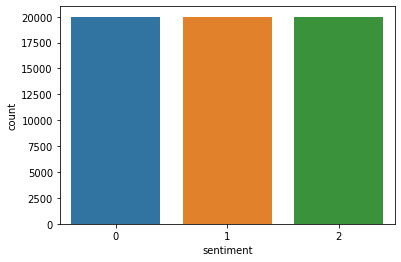

In [5]:
sns.countplot(df["sentiment"])

In [6]:
df.isna().sum()

review       0
rating       0
sentiment    0
dtype: int64

In [7]:
df = df.dropna(axis=0)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 0 to 59999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     60000 non-null  object
 1   rating     60000 non-null  int64 
 2   sentiment  60000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.8+ MB


### Cleaning

In [9]:
def preprocessing_text(texts):
    texts = re.sub(r'<.*?>', '', texts)
    texts = re.sub(r'[^a-zA-Z]', ' ', texts)
    texts = list(filter(lambda x: x, [x.lower() for x in texts.split(" ")]))

    return texts

In [10]:
df['review_cleaned'] = df['review'].apply(lambda x : preprocessing_text(x))

In [11]:
df.head()

,review,rating,sentiment,review_cleaned
0,Pokoknya suka banget:),5,2,"[pokoknya, suka, banget]"
1,Coba dulu .....bagus pake teruus,4,2,"[coba, dulu, bagus, pake, teruus]"
2,sangat mudah membeli pelatihan prakerja di tok...,5,2,"[sangat, mudah, membeli, pelatihan, prakerja, ..."
3,"Alhamdulillah senang krn gratis ongkir,,,biarp...",5,2,"[alhamdulillah, senang, krn, gratis, ongkir, b..."
4,komplit,5,2,[komplit]


In [12]:
word_length = []
for row in df['review_cleaned']:
    word_length.append(len(row))

display(pd.DataFrame(word_length, columns=['word_length']).describe())
display(pd.DataFrame(word_length, columns=['word_length']).quantile(0.90))

,word_length
count,60000.000000
mean,10.982883
std,13.767037
min,0.000000
25%,2.000000
50%,6.000000
75%,14.000000
max,157.000000


word_length    28.0
Name: 0.9, dtype: float64

In [13]:
sentiment_onehot = pd.DataFrame(pd.get_dummies(df['sentiment']))

## 2. LSTM Model

### Tokenize & Padding

In [14]:
tokenizer = Tokenizer(num_words=10000)

In [15]:
tokenizer.fit_on_texts(df['review_cleaned'])
seq = tokenizer.texts_to_sequences(df['review_cleaned'])
X = pad_sequences(seq, padding='post')

print(f'X_shape: {X.shape}, X_min: {np.min(X)}, X_max: {np.max(X)}')

X_shape: (60000, 155), X_min: 0, X_max: 9999


In [16]:
y = sentiment_onehot

In [17]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)
print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)

(38400, 155) (9600, 155) (12000, 155) (38400, 3) (9600, 3) (12000, 3)


In [18]:
y_train

,0,1,2
474,0,0,1
35650,1,0,0
9103,0,0,1
16233,0,0,1
7756,0,0,1
...,...,...,...
54559,0,1,0
58174,0,1,0
18174,0,0,1
2480,0,0,1


### Create Model Layers

In [19]:
embed_size = 64
model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=10000, output_dim=embed_size, input_shape=[None], mask_zero=True),
    keras.layers.LSTM(64),
    keras.layers.Dense(3, activation='sigmoid')
])
model.summary()

2022-01-08 02:40:42.620249: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-08 02:40:42.620312: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-08 02:40:42.620361: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (skripsi-openlineage): /proc/driver/nvidia/version does not exist
2022-01-08 02:40:42.620769: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 673,219
Trainable params: 673,219
Non-trainable params: 0
_________________________________________________________________


### Training Model

In [20]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
1200/1200 [==============================] - 149s 121ms/step - loss: 0.7876 - accuracy: 0.6461 - val_loss: 0.7372 - val_accuracy: 0.6721
Epoch 2/5
1200/1200 [==============================] - 144s 120ms/step - loss: 0.6846 - accuracy: 0.7055 - val_loss: 0.7431 - val_accuracy: 0.6686
Epoch 3/5
1200/1200 [==============================] - 143s 119ms/step - loss: 0.6389 - accuracy: 0.7280 - val_loss: 0.7648 - val_accuracy: 0.6661
Epoch 4/5
1200/1200 [==============================] - 146s 121ms/step - loss: 0.6000 - accuracy: 0.7460 - val_loss: 0.7853 - val_accuracy: 0.6666
Epoch 5/5
1200/1200 [==============================] - 148s 123ms/step - loss: 0.5596 - accuracy: 0.7630 - val_loss: 0.8238 - val_accuracy: 0.6571


<AxesSubplot:>

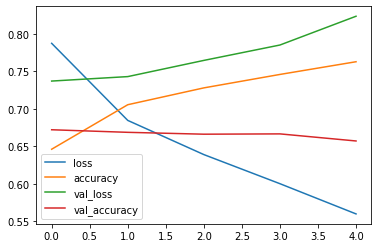

In [21]:
pd.DataFrame(history.history).plot()

### Evaluating Model

              precision    recall  f1-score   support

           0       0.70      0.62      0.66      4014
           1       0.58      0.50      0.54      4023
           2       0.68      0.85      0.76      3963

    accuracy                           0.66     12000
   macro avg       0.65      0.66      0.65     12000
weighted avg       0.65      0.66      0.65     12000



<AxesSubplot:>

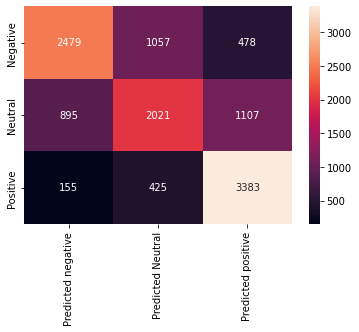

In [38]:
y_test = np.argmax(y_test.to_numpy(), axis=1)
y_pred = np.argmax(model.predict(X_test), axis=-1)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted Neutral', 'Predicted positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'])